## 1. Importing Libraries

In [1]:
# Data Manipulation
import numpy as np
import pandas as pd

# Data preprocessing 
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from PIL import Image, ImageEnhance
from sklearn.preprocessing import LabelBinarizer

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


#Data Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Miscellaneous
from tqdm import tqdm
import os
import random

## 2. Reading the Data

In [2]:
def read_dataset(data_path):
    data = []

    for label in os.listdir(data_path):
        real_label = ""
        if label in ['pituitary_tumor', 'pituitary']: 
            real_label = 'pituitary'
        elif label in ['no_tumor', 'notumor']:
            real_label = 'notumor'
        elif label in ['meningioma', 'meningioma_tumor']:
            real_label = 'meningioma'
        elif label in ['glioma', 'glioma_tumor']:
            real_label = 'glioma'
        for image in os.listdir(os.path.join(data_path,label)):
            data.append([os.path.join(data_path,label,image),real_label])
            
    return data

### 2.1. Setting the Base Directory and Subdirectories:

In [3]:
image_data_paths = "C:\\Users\\tmost\\Documents\\Data-course\\Brain" # base directory where the brain image data is located
train_dir = os.path.join(image_data_paths,"Training")
test_dir = os.path.join(image_data_paths,"Testing")


train_data = shuffle(read_dataset(train_dir))
print(f'training image number: {len(train_data)}')

test_data = read_dataset(test_dir)
print(f'test image number: {len(test_data)}')

training image number: 2870
test image number: 394


In [4]:
train_data = pd.DataFrame(train_data, columns = ['image_filepaths', 'tumor_class']).sample(frac = 1, random_state = 42).reset_index(drop = True)
train_data.head(2)

,image_filepaths,tumor_class
0,C:\Users\tmost\Documents\Data-course\Brain\Tra...,meningioma
1,C:\Users\tmost\Documents\Data-course\Brain\Tra...,glioma


In [5]:
test_data = pd.DataFrame(test_data, columns = ['image_filepaths', 'tumor_class']).sample(frac = 1, random_state = 42).reset_index(drop = True)
test_data.head(2)

,image_filepaths,tumor_class
0,C:\Users\tmost\Documents\Data-course\Brain\Tes...,glioma
1,C:\Users\tmost\Documents\Data-course\Brain\Tes...,notumor


## 3. Data Visualization Distribution for each class

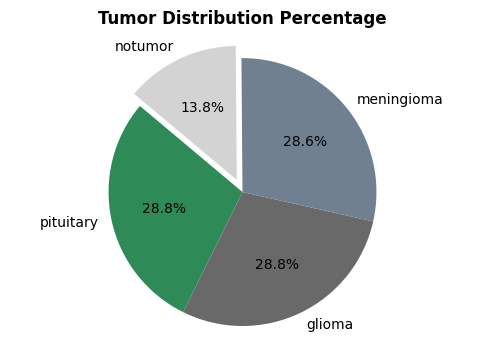

In [6]:
label_counts = train_data['tumor_class'].value_counts().to_dict()  # Count occurrences of each label
total_count = sum(label_counts.values())  
label_percentages = {label: count / total_count * 100 for label, count in label_counts.items()}  

# Create a pie chart
plt.figure(figsize=(6, 4))
colors = ['seagreen', 'dimgray', 'slategrey', 'lightgray']
explode = (0, 0,0,0.1) #Explode the 1st slice (optional, for emphasis)
plt.pie(label_percentages.values(), labels=label_percentages.keys(), autopct='%1.1f%%', startangle=140, colors=colors, explode=explode)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Tumor Distribution Percentage',weight='bold')
plt.show()

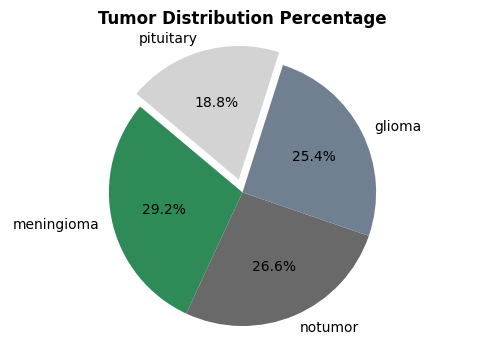

In [7]:
label_counts = test_data['tumor_class'].value_counts().to_dict()  # Count occurrences of each label
total_count = sum(label_counts.values())  
label_percentages = {label: count / total_count * 100 for label, count in label_counts.items()}  

# Create a pie chart
plt.figure(figsize=(6, 4))
colors = ['seagreen', 'dimgray', 'slategrey', 'lightgray']
explode = (0, 0,0,0.1) #Explode the 1st slice (optional, for emphasis)
plt.pie(label_percentages.values(), labels=label_percentages.keys(), autopct='%1.1f%%', startangle=140, colors=colors, explode=explode)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Tumor Distribution Percentage',weight='bold')
plt.show()

## 4. Splitting Training Data into Training and Validation Sets:

In [8]:
train_data, val_data = train_test_split(train_data, 
                                               train_size = 0.80, 
                                               random_state = 42, 
                                               stratify = train_data.tumor_class)

In [9]:
print(train_data.shape), print(val_data.shape), print(test_data.shape)

(2296, 2)
(574, 2)
(394, 2)


(None, None, None)

## 5. Data Agumentation and Normalization(Rescaling)

- **Image augmentation** is a technique employed in ML for two primary purposes: to **expand the image dataset** and **enhance the neural network's resilience to translation invariance**.



- This involves generating additional images by applying operations such as flipping, rotating, zooming, and adjusting brightness to the original dataset.

-  Only apply rescalling to test data as we want to introduce new variations to the data, as the model should be evaluated on its ability to make predictions on unseen, unaltered data.

In [10]:
image_size = 128
batch_size = 32  # nr of samples(images) in each batch during the training

train_image_datagen_kwargs = dict(rescale = 1 / 255,  
                                rotation_range = 15, 
                                width_shift_range = 0.1, 
                                zoom_range = 0.01, 
                                shear_range = 0.01,
                                brightness_range = [0.3, 1.5],
                                horizontal_flip = True,
                                vertical_flip = True)

test_image_datagen_kwargs = dict(rescale = 1 / 255) # only rescale on test

## 6. Data Generator

In [11]:
train_image_datagen = ImageDataGenerator(**train_image_datagen_kwargs) #generating batches of training data with augmentation.
val_image_datagen = ImageDataGenerator(**test_image_datagen_kwargs)#generating batches of validation data without augmentation.
test_image_datagen = ImageDataGenerator(**test_image_datagen_kwargs)#generating batches of test data without augmentation.

- flow_from_dataframe allows you to apply these augmentations on-the-fly during training.

In [12]:
train_dataset = train_image_datagen.flow_from_dataframe(train_data,  
                                                        x_col = 'image_filepaths', 
                                                        y_col = 'tumor_class', 
                                                        seed = 42, 
                                                        batch_size = batch_size,
                                                        target_size = (image_size, image_size),
                                                        color_mode = 'rgb')

val_dataset = val_image_datagen.flow_from_dataframe(val_data, 
                                                        x_col = 'image_filepaths', 
                                                        y_col = 'tumor_class', 
                                                        seed = 42, 
                                                        batch_size = batch_size,
                                                        target_size = (image_size, image_size),
                                                        color_mode = 'rgb')


test_dataset = test_image_datagen.flow_from_dataframe(test_data, 
                                                      x_col = 'image_filepaths', 
                                                      y_col = 'tumor_class', 
                                                      seed = 42, 
                                                      batch_size = batch_size,
                                                      target_size = (image_size, image_size),
                                                      color_mode = 'rgb')

Found 2296 validated image filenames belonging to 4 classes.
Found 574 validated image filenames belonging to 4 classes.
Found 394 validated image filenames belonging to 4 classes.


In [13]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 10)

- The EarlyStopping callback in Keras is used to stop training the neural network model when a monitored metric has stopped improving. 

- The "monitor" is like a metric that the callback keeps an eye on to see if things are getting better. In this situation, it's looking at 'val_accuracy,' which means it's checking how well the model is doing on the validation data.


- The "patience" is the number of epochs with no improvement after which training will be stopped. here, if the validation accuracy does not improve for 10 consecutive epochs, the training will be stopped.

In [14]:
unique_labels = ['glioma','meningioma','notumor','pituitary']#os.listdir(train_dir)

## Transfer Learning

In [ ]:
# add text about transfer learning

## Model

In [15]:
base_model = VGG16(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet') 
# Set all layers to non-trainable
for layer in base_model.layers:  # loop through all layers in VGG16
    layer.trainable = False    
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True   #unfreeze the last 3 layers
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True


# build a custom model of VGG16
model = Sequential()    
model.add(Input(shape=(image_size,image_size,3))) # add input layer with the specified shape
model.add(base_model) #Adds the pre-trained VGG16 base model to the model.
model.add(Flatten())  #Flattens the output of the VGG16 base
model.add(Dropout(0.3)) # Applies dropout with a rate of 0.3 to reduce overfitting.
model.add(Dense(128, activation='relu')) # Adds a fully connected layer with 128 units and ReLU activation.
model.add(Dropout(0.2)) # Applies another dropout with a rate of 0.2.
model.add(Dense(len(unique_labels), activation='softmax')) #adds the final dense layer

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15,763,908
Trainable params: 8,128,644
Non

In [17]:
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [18]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])

## Train Model

In [19]:
%%time
train_history = model.fit(train_dataset,
                          batch_size = batch_size,
                          validation_data = val_dataset,
                          epochs = 10, 
                          callbacks = [early_stopping])

Epoch 1/10
72/72 [==============================] - 427s 6s/step - loss: 1.0365 - categorical_accuracy: 0.5566 - val_loss: 0.7313 - val_categorical_accuracy: 0.7265
Epoch 2/10
72/72 [==============================] - 392s 5s/step - loss: 0.6666 - categorical_accuracy: 0.7326 - val_loss: 0.5011 - val_categorical_accuracy: 0.7909
Epoch 3/10
72/72 [==============================] - 390s 5s/step - loss: 0.5410 - categorical_accuracy: 0.7840 - val_loss: 0.4161 - val_categorical_accuracy: 0.8362
Epoch 4/10
72/72 [==============================] - 391s 5s/step - loss: 0.4556 - categorical_accuracy: 0.8249 - val_loss: 0.3573 - val_categorical_accuracy: 0.8537
Epoch 5/10
72/72 [==============================] - 394s 5s/step - loss: 0.3898 - categorical_accuracy: 0.8441 - val_loss: 0.3774 - val_categorical_accuracy: 0.8380
Epoch 6/10
72/72 [==============================] - 388s 5s/step - loss: 0.3687 - categorical_accuracy: 0.8615 - val_loss: 0.2965 - val_categorical_accuracy: 0.8955
Epoch 7/10

In [31]:
print(train_history.history.keys())


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


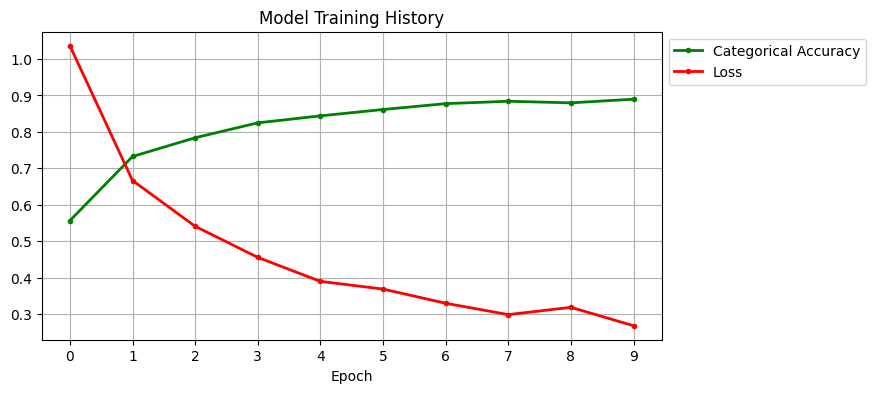

In [32]:
plt.figure(figsize=(8, 4))
plt.grid(True)
plt.plot(train_history.history['categorical_accuracy'], '.g-', linewidth=2, label='Categorical Accuracy')
plt.plot(train_history.history['loss'], '.r-', linewidth=2, label='Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.xticks(range(len(train_history.history['categorical_accuracy'])))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


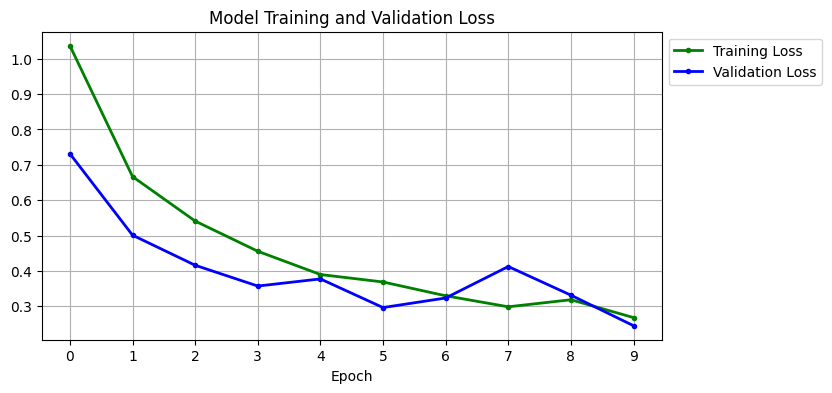

In [33]:
plt.figure(figsize=(8, 4))
plt.grid(True)

# Plot training loss
plt.plot(train_history.history['loss'], '.g-', label='Training Loss', linewidth=2)

# Plot validation loss if available
if 'val_loss' in train_history.history:
    plt.plot(train_history.history['val_loss'], '.b-', label='Validation Loss', linewidth=2)

plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.xticks(range(len(train_history.history['loss'])))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


- The plot shows how the loss changes over the course of training and whether the model converges or overfits

The appearance of the lines indicating convergence in a loss plot depends on the specific behavior of the training process. Here are some common scenarios and what the lines might look like:

1. **Convergence**:
   - Both training and validation loss decrease steadily over epochs.
   - The lines gradually decrease and stabilize.

   ![Convergence](https://i.imgur.com/xsXNXXt.png)

2. **Overfitting**:
   - Training loss decreases, but validation loss starts increasing.
   - The lines start to diverge as the model becomes overly specialized to the training data.

   ![Overfitting](https://i.imgur.com/9OyxEDv.png)

3. **Underfitting**:
   - Both training and validation loss remain high.
   - The lines may not show a clear decreasing trend.

   ![Underfitting](https://i.imgur.com/46QF5d6.png)

4. **Ideal Convergence**:
   - Both training and validation loss decrease steadily and reach a low value.
   - The lines are close to each other and maintain a downward trend.

   ![Ideal Convergence](https://i.imgur.com/z89MXm3.png)

In general, you want to see both training and validation loss decreasing and converging. However, if the training loss decreases significantly while the validation loss increases, it may indicate overfitting. Monitoring the validation loss is crucial to detect when the model starts to generalize poorly to new, unseen data.

Your specific plot might look different depending on the complexity of your model, the amount of data, and the specifics of your problem. The key is to observe trends and patterns that give insights into the training process.

## Evaluate Model with test samples

In [36]:
# Evaluate the model on the test set
evaluation_results = model.evaluate(test_dataset)

# Print the evaluation results
print(f'Test Loss: {evaluation_results[0]}')
print(f'Test Accuracy: {evaluation_results[1]}')


13/13 [==============================] - 45s 4s/step - loss: 1.2118 - categorical_accuracy: 0.7234
Test Loss: 1.211828351020813
Test Accuracy: 0.7233502268791199


In [42]:
# confusion_matrix

conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)

[[ 391  533  350   66]
 [  42 1355  135   14]
 [  66   26 1306    0]
 [  40   82  109  767]]


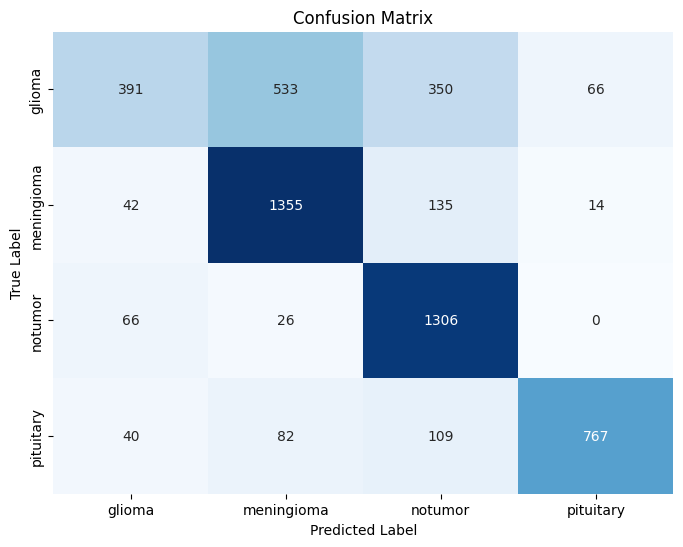

In [44]:
conf_matrix_data = np.array(conf_matrix)
                           

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_data, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=unique_labels,
            yticklabels=unique_labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

- The diagonal elements represent correctly predicted instances (True Positives).


- Off-diagonal elements represent misclassifications (False Positives and False Negatives).


- The higher the diagonal values of the confusion matrix, the better the model's performance.


- The values on the diagonal of the confusion matrix represent the number of correctly classified instances for each class.

**Observation:**


- For Glioma (Class 0): The model correctly identified 391 instances of Glioma (TP), but there were X instances misclassified as other classes ('meningioma', 'notumor', or 'pituitary').


- For Meningioma (Class 1): The model correctly identified 1355 instances of Meningioma (TP), and there was X misclassification.



- No Tumor (Class 2):The model correctly identified 1305 instances of No Tumor (TP), and there was  X misclassification.



- Pituitary (Class 3) : The model correctly identified 767 instances of Pituitary (TP), but there were 19 instances misclassified as other classes.



- In conclusion, The model has a noticeable number of misclassifications, especially in the 'glioma' class (Class 0) and the 'pituitary' class (Class 3).



- Further analysis, such as examining precision, recall, and F1-score for each class, could provide a more comprehensive evaluation of the model's strengths and weaknesses. Additionally, fine-tuning the model, adjusting hyperparameters, or using more advanced architectures may help improve performance.


In [48]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.29      0.42      1340
           1       0.68      0.88      0.77      1546
           2       0.69      0.93      0.79      1398
           3       0.91      0.77      0.83       998

    accuracy                           0.72      5282
   macro avg       0.75      0.72      0.70      5282
weighted avg       0.74      0.72      0.70      5282



In [49]:
# Save the VGG16 model
save_path = 'C:\\Users\\tmost\\Documents\\Data-course\\Brain\\saved_models'
model.save(os.path.join(save_path, 'vgg16_model.h5'))

In [ ]:
FP =[]
for i, y in enumerate(y_pred):
    if y != y_true[i]:
        FP.append(i)
        
FP_paths = []
FP_labels = []


for y in FP: 
    FP_paths.append(test_paths[y])
    FP_labels.append(y_true[y]+'-'+y_pred[y])
    

In [ ]:
IMAGE_SIZE = 128


images = open_images(FP_paths[0:20])
labels = FP_labels[0:20]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 19):
    fig.add_subplot(4, 6, x)
    plt.axis('off')
    plt.title(labels[x], fontsize=8)
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 8})
plt.show()

In [ ]:
import h5py
mat_file = h5py.File(r'C:\\Users\tmost\Documents\Data-course\Brain\brain_tumor_dataset\cvind.mat')
arrays = {}
for k, v in mat_file.items():
    arrays[k] = np.array(v)

In [ ]:
arrays